# Predicting CO2 emissions of passenger cars sold in the EU

In this notebook, we investigate a public dataset related to the
[Monitoring of CO2 emissions from passenger cars Regulation (EU) 2019/631](https://www.eea.europa.eu/en/datahub/datahubitem-view/fa8b1229-3db6-495d-b18e-9c9b3267c02b).

According to the European Environment Agency (EEA):
> The Regulation (EU) No 2019/631 requires Countries to record information for each new passenger car registered in its territory. Every year, each Member State shall submit to the Commission all the information related to their new registrations. In particular, the following details are required for each new passenger car registered: manufacturer name, type approval number, type, variant, version, make and commercial name, specific emissions of CO2 (NEDC and WLTP protocols), masses of the vehicle, wheel base, track width, engine capacity and power, fuel type and mode, eco-innovations and electricity consumption. Data for EU-27 and UK are reported in the main database.

Our goal is to understand what this dataset contains in order to design a machine
learning model capable of predicting CO2 emissions based on vehicle specs.

## Notebook basics

### How to run a notebook cell

Notebooks allow users to run:
- Python code by simply writing a valid Python expression
- shell commands like in a terminal by using an exclamation mark `!`.

To run the cells below:
1. select the cell with your mouse
2. press shift+enter or press the play button

In [1]:
# this is a Python cell
'a' * 3

'aaa'

In [2]:
# this is a shell command
!echo 'aaa'

aaa


In [3]:
# this is a Python cell that fails
'a' + 3

TypeError: can only concatenate str (not "int") to str

## Loading the dataset

The dataset we are working with has been downloaded from the [EEA website](https://co2cars.apps.eea.europa.eu/?source=%7B%22track_total_hits%22%3Atrue%2C%22query%22%3A%7B%22bool%22%3A%7B%22must%22%3A%5B%7B%22constant_score%22%3A%7B%22filter%22%3A%7B%22bool%22%3A%7B%22must%22%3A%5B%7B%22bool%22%3A%7B%22should%22%3A%5B%7B%22term%22%3A%7B%22year%22%3A%222015%22%7D%7D%5D%7D%7D%2C%7B%22bool%22%3A%7B%22should%22%3A%5B%7B%22term%22%3A%7B%22scStatus%22%3A%22Final%22%7D%7D%5D%7D%7D%5D%7D%7D%7D%7D%5D%7D%7D%2C%22display_type%22%3A%22tabular%22%2C%22from%22%3A10%7D)
where we selected status: Final and year: 2015 as filters.

### Downloading the passenger car data

In [5]:
!wget https://sdi.eea.europa.eu/datashare/s/xgTiQR2KAmAF9en/download

--2024-01-23 15:40:16--  https://sdi.eea.europa.eu/datashare/s/xgTiQR2KAmAF9en/download


Resolving sdi.eea.europa.eu (sdi.eea.europa.eu)... 87.54.7.149
Connecting to sdi.eea.europa.eu (sdi.eea.europa.eu)|87.54.7.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘download’

download                [     <=>            ] 208,08M  10,2MB/s    in 19s     

2024-01-23 15:40:35 (10,7 MB/s) - ‘download’ saved [218189274]



In [6]:
!unzip download

Archive:  download
   creating: eea_t_co2-emissions-cars-final-2015_p_2015_v01_r00/
 extracting: eea_t_co2-emissions-cars-final-2015_p_2015_v01_r00/770aa0a5-83ce-4663-93fa-78507f1990d6.xml  
 extracting: eea_t_co2-emissions-cars-final-2015_p_2015_v01_r00/CO2_passenger_cars_v12.csv  


 extracting: eea_t_co2-emissions-cars-final-2015_p_2015_v01_r00/CO2_passenger_cars_v12.mdb  


In [4]:
!head eea_t_co2-emissions-cars-final-2015_p_2015_v01_r00/CO2_passenger_cars_v12.csv  

id	MS	MP	Mh	Man	MMS	TAN	T	Va	Ve	Mk	Cn	Ct	r	e (g/km)	m (kg)	w (mm)	at1 (mm)	at2 (mm)	Ft	Fm	ec (cm3)	ep (KW)	z (Wh/km)	It	Er (g/km)
346261	LU	VW GROUP PC	VOLKSWAGEN	VOLKSWAGEN AG	VOLKSWAGEN AG	E1*2007/46*0623*09	AU	AC4CRBCX0	FD6FD6D9004N7MJOMLVR2	VOLKSWAGEN	GOLF	M1	3	119	1376	2620	1527	1496	DIESEL	M	1968	110			
346262	LU	VW GROUP PC	VOLKSWAGEN	VOLKSWAGEN AG	VOLKSWAGEN AG	E1*2007/46*0623*17	AU	GAC4CHHBX0	FD6FD6D9011S7MMON1ML71VR2	VOLKSWAGEN	GOLF	M1	3	145	1392	2626	1527	1496	PETROL	M	1984	162			
346263	LU	VW GROUP PC	VOLKSWAGEN	VOLKSWAGEN AG	VOLKSWAGEN AG	E1*2001/116*0356*17	2EC2	KN4D1350N	MEC24VD9	VOLKSWAGEN	CRAFTER	M1	1	209	2356	3665	1710	1716	DIESEL	M	1968	120			
346264	LU	VW GROUP PC	VOLKSWAGEN	VOLKSWAGEN AG	VOLKSWAGEN AG	E1*2007/46*0539*13	16	AECTHDX0	FD7FD7AM006N7MJVIVR0	VOLKSWAGEN	BEETLE	M1	1	148	1468	2538	1570	1548	PETROL	M	1390	118			
346265	LU	VW GROUP PC	VOLKSWAGEN	VOLKSWAGEN AG	VOLKSWAGEN AG	E1*2007/46*0539*14	16	ABCFFBX0	FD6FD62E018N7MJVIVR0	VOLKSWAGEN	BEETLE	M1	1	140	1411	252

In [5]:
import pandas as pd

In [8]:
dd_eu_cars = (
    pd.read_csv(
        filepath_or_buffer='eea_t_co2-emissions-cars-final-2015_p_2015_v01_r00/CO2_passenger_cars_v12.csv',
        sep='\t',
        engine='pyarrow',
    )
    .rename(
        axis='columns',
        mapper={
            # 'id', 'MS', 'MP', 'Mh', 'Man', 'MMS', 'TAN', 'T', 'Va', 'Ve', 'Mk',
            # 'Cn', 'Ct', 'r', 'e (g/km)', 'm (kg)', 'w (mm)', 'at1 (mm)', 'at2 (mm)',
            # 'Ft', 'Fm', 'ec (cm3)', 'ep (KW)', 'z (Wh/km)', 'It', 'Er (g/km)'
            'id': 'vehicle_id',
            'MS': 'country',
            'MP': 'pool',
            'Mh': 'manufacturer_name_eu',
            'Man': 'manufacturer_name_self_reported',
            'MMS': 'manufacturer_name_registry',
            'TAN': 'type_approval_number',
            'T': 'type',
            'Va': 'variant',
            'Ve': 'version',
            'Mk': 'make',
            'Cn': 'commercial_name',
            'Ct': 'approved_vehicle_type_category',
            'r': 'total_new_registrations',
            'e (g/km)': 'co2_emissions_in_grams_per_km',
            'm (kg)': 'mass_running_order_in_kg',
            'w (mm)': 'wheel_base_in_mm',
            'at1 (mm)': 'steering_axle_width_in_mm',
            'at2 (mm)': 'other_axle_width_in_mm',
            'Ft': 'raw_fuel_type',
            'Fm': 'fuel_mode',
            'ec (cm3)': 'engine_capacity_in_cm3',
            'ep (KW)': 'engine_power_in_kilowatts',
            'z (Wh/km)': 'electric_energy_consumption_in_watthours_per_km',
            'It': 'innovative_technology',
            'Er (g/km)': 'co2_emissions_reduction_in_grams_per_km',
        },
    )
    .assign(
        fuel_type=lambda x: x.raw_fuel_type
            .str.lower()
            .str.replace('petrol phev', 'petrol-electric')
            .str.replace('hybrid/petrol/e', 'petrol-electric')
            .str.replace('/', '-')
    )
    .astype(
        {
            c: 'category' for c in
            ['country', 'fuel_type', 'fuel_mode', 'pool', 'manufacturer_name_eu']
        }
    )
    .dropna(axis='columns', how='all')
    .set_index('vehicle_id')
)

dd_eu_cars

,country,pool,manufacturer_name_eu,manufacturer_name_self_reported,manufacturer_name_registry,type_approval_number,type,variant,version,make,...,steering_axle_width_in_mm,other_axle_width_in_mm,raw_fuel_type,fuel_mode,engine_capacity_in_cm3,engine_power_in_kilowatts,electric_energy_consumption_in_watthours_per_km,innovative_technology,co2_emissions_reduction_in_grams_per_km,fuel_type
vehicle_id,,,,,,,,,,,,,,,,,,,,,
346261,LU,VW GROUP PC,VOLKSWAGEN,VOLKSWAGEN AG,VOLKSWAGEN AG,E1*2007/46*0623*09,AU,AC4CRBCX0,FD6FD6D9004N7MJOMLVR2,VOLKSWAGEN,...,1527.0,1496.0,DIESEL,M,1968.0,110.0,NaN,None,NaN,diesel
346262,LU,VW GROUP PC,VOLKSWAGEN,VOLKSWAGEN AG,VOLKSWAGEN AG,E1*2007/46*0623*17,AU,GAC4CHHBX0,FD6FD6D9011S7MMON1ML71VR2,VOLKSWAGEN,...,1527.0,1496.0,PETROL,M,1984.0,162.0,NaN,None,NaN,petrol
346263,LU,VW GROUP PC,VOLKSWAGEN,VOLKSWAGEN AG,VOLKSWAGEN AG,E1*2001/116*0356*17,2EC2,KN4D1350N,MEC24VD9,VOLKSWAGEN,...,1710.0,1716.0,DIESEL,M,1968.0,120.0,NaN,None,NaN,diesel
346264,LU,VW GROUP PC,VOLKSWAGEN,VOLKSWAGEN AG,VOLKSWAGEN AG,E1*2007/46*0539*13,16,AECTHDX0,FD7FD7AM006N7MJVIVR0,VOLKSWAGEN,...,1570.0,1548.0,PETROL,M,1390.0,118.0,NaN,None,NaN,petrol
346265,LU,VW GROUP PC,VOLKSWAGEN,VOLKSWAGEN AG,VOLKSWAGEN AG,E1*2007/46*0539*14,16,ABCFFBX0,FD6FD62E018N7MJVIVR0,VOLKSWAGEN,...,1570.0,1546.0,DIESEL,M,1968.0,103.0,NaN,None,NaN,diesel
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106455,DE,NaN,ASTON MARTIN,ASTON MARTIN LAGONDA LTD,ASTON MARTIN (GB),e11*KS07/46*0208*02,VHS(SF),SF12,L2RSDH,ASTON MARTIN,...,1570.0,1575.0,Petrol,M,5935.0,422.0,NaN,None,NaN,petrol
106456,DE,NaN,ASTON MARTIN,ASTON MARTIN LAGONDA LTD,ASTON MARTIN (GB),e11*KS07/46*0208*02,VH2(SF),SF12,L2RSDH,ASTON MARTIN,...,1570.0,1575.0,Petrol,M,5935.0,422.0,NaN,None,NaN,petrol
106457,DE,NaN,ASTON MARTIN,ASTON MARTIN LAGONDA LTD,ASTON MARTIN (GB),e11*KS07/46*0208*03,VH2(SF),SF12,L2RSDH,ASTON MARTIN,...,1570.0,1575.0,Petrol,M,5935.0,422.0,NaN,None,NaN,petrol


In [9]:
dd_eu_cars.info()

<class 'pandas.core.frame.DataFrame'>
Index: 440645 entries, 346261 to 240654
Data columns (total 26 columns):
 #   Column                                           Non-Null Count   Dtype   
---  ------                                           --------------   -----   
 0   country                                          440645 non-null  category
 1   pool                                             382812 non-null  category
 2   manufacturer_name_eu                             440645 non-null  category
 3   manufacturer_name_self_reported                  440645 non-null  object  
 4   manufacturer_name_registry                       416338 non-null  object  
 5   type_approval_number                             428046 non-null  object  
 6   type                                             437911 non-null  object  
 7   variant                                          434992 non-null  object  
 8   version                                          426616 non-null  object  
 9   make

Notice that the output of the command is written directly below the cell.
This will also be the case for figures and tables.

Observations
- the first row contains column names, most of which are very abbreviated
- some column names come with physical units
- numerical values seem to be represented as integers
- non-numerical values are either strings or codes

## Exploratory data analysis

In [10]:
import seaborn as sns

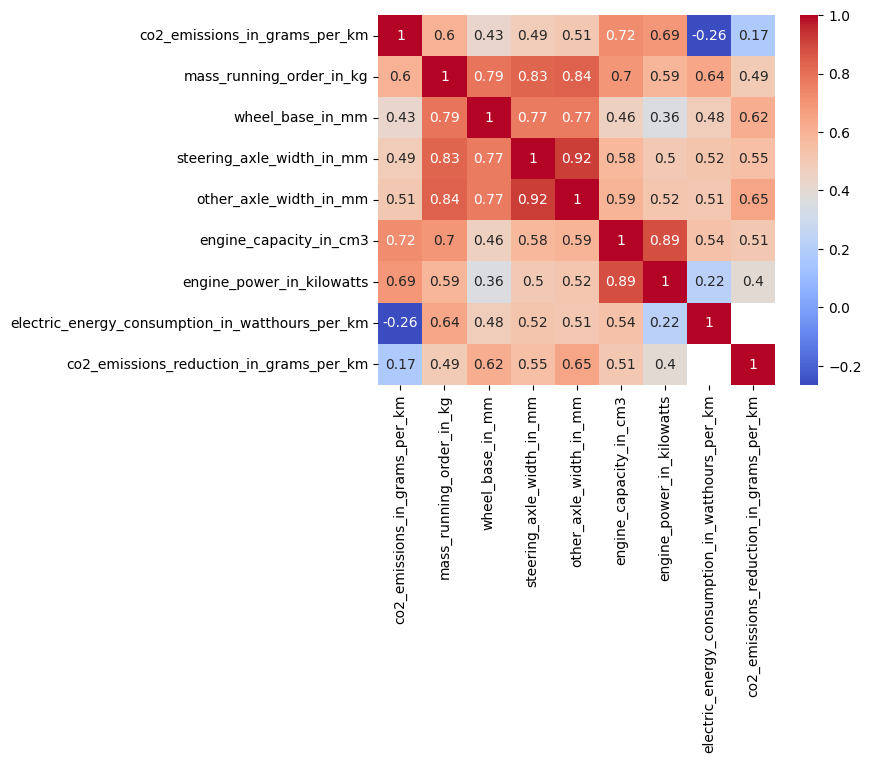

In [11]:
sns.heatmap(
    data=(
        dd_eu_cars
        .select_dtypes(include=['int64', 'float64'])
        .drop(axis='columns', labels='total_new_registrations')
        .corr()
    ),
    cmap='coolwarm',
    annot=True,
);

/Users/beaujeanpaul/Projects/intro-to-ai/.env/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/beaujeanpaul/Projects/intro-to-ai/.env/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


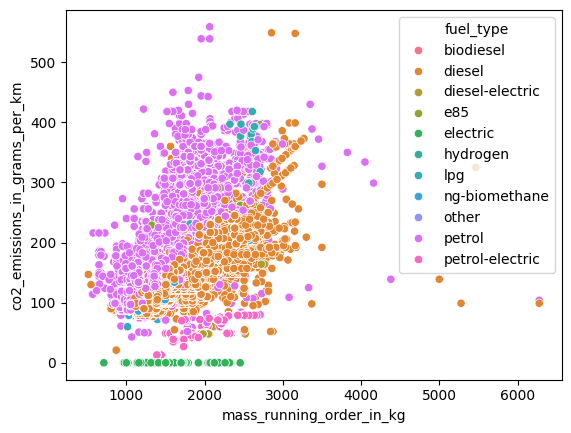

In [12]:
sns.scatterplot(
    data=dd_eu_cars,
    x='mass_running_order_in_kg',
    y='co2_emissions_in_grams_per_km',
    hue='fuel_type',
);

In [13]:
[column_name for column_name in dd_eu_cars.columns if 'co2' in column_name]

['co2_emissions_in_grams_per_km', 'co2_emissions_reduction_in_grams_per_km']

In [16]:
dd_eu_cars.co2_emissions_in_grams_per_km.isnull().sum()

797

<Axes: ylabel='Frequency'>

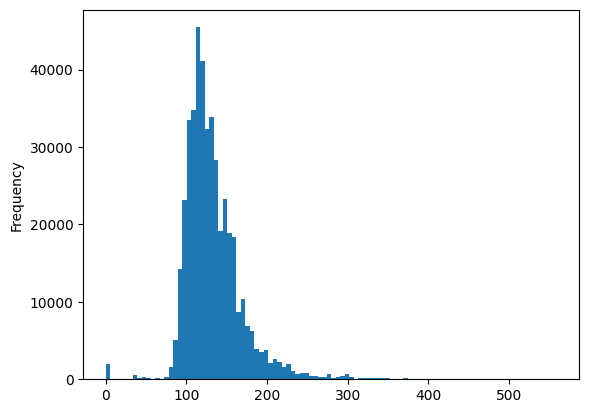

In [18]:
dd_eu_cars.co2_emissions_in_grams_per_km.plot.hist(bins=100)

In [20]:
from sklearn.model_selection import train_test_split

X = (
    dd_eu_cars
    [~dd_eu_cars.co2_emissions_in_grams_per_km.isnull()]
    [[
        # numerics
        'total_new_registrations',
        'mass_running_order_in_kg',
        'wheel_base_in_mm',
        'steering_axle_width_in_mm',
        'other_axle_width_in_mm',
        'engine_capacity_in_cm3',
        'engine_power_in_kilowatts',
        'electric_energy_consumption_in_watthours_per_km',
        # categories
        'country',
        'pool',
        'fuel_mode',
        'fuel_type'
    ]]
)

y = (
    dd_eu_cars
    [~dd_eu_cars.co2_emissions_in_grams_per_km.isnull()]
    .co2_emissions_in_grams_per_km
)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 351878 entries, 267881 to 361633
Data columns (total 12 columns):
 #   Column                                           Non-Null Count   Dtype   
---  ------                                           --------------   -----   
 0   total_new_registrations                          351878 non-null  int64   
 1   mass_running_order_in_kg                         351805 non-null  float64 
 2   wheel_base_in_mm                                 343461 non-null  float64 
 3   steering_axle_width_in_mm                        344515 non-null  float64 
 4   other_axle_width_in_mm                           332022 non-null  float64 
 5   engine_capacity_in_cm3                           350268 non-null  float64 
 6   engine_power_in_kilowatts                        291506 non-null  float64 
 7   electric_energy_consumption_in_watthours_per_km  2405 non-null    float64 
 8   country                                          351878 non-null  category
 9   pool

In [22]:
y_train.info()

<class 'pandas.core.series.Series'>
Index: 351878 entries, 267881 to 361633
Series name: co2_emissions_in_grams_per_km
Non-Null Count   Dtype  
--------------   -----  
351878 non-null  float64
dtypes: float64(1)
memory usage: 5.4 MB


In [23]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline
import numpy as np

ordinal_encoder = make_column_transformer(
    (
        OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan),
        make_column_selector(dtype_include="category"),
    ),
    remainder="passthrough",
    verbose_feature_names_out=False,
).set_output(transform='pandas')

In [24]:
from sklearn.ensemble import HistGradientBoostingRegressor

hist_native = make_pipeline(
    ordinal_encoder,
    HistGradientBoostingRegressor(random_state=42),
)

In [25]:
hist_native.fit(X_train, y_train)

transformed_X_test = hist_native.steps[0][1].fit_transform(X_test)
y_pred = hist_native.steps[1][1].predict(transformed_X_test)

In [26]:
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    median_absolute_error,
    max_error,
)

mse = mean_squared_error(y_true=y_test, y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test, y_pred=y_pred)
r2 = r2_score(y_true=y_test, y_pred=y_pred)
medae = median_absolute_error(y_true=y_test, y_pred=y_pred)
maxe = max_error(y_true=y_test, y_pred=y_pred)

print(
    f"""
    Mean Squared Error (MSE): {mse:.2f} [penalizes large deviations]
    Root Mean Squared Error (RMSE): {np.sqrt(mse):.2f} [MSE scaled to original quantity]
    Mean Absolute Error (MAE): {mae:.2f} [penalizes deviations proportionally]
    Median Absolute Error (MedAE): {medae:.2f} [similar to MAE but robust to outliers]
    Maximum Error: {maxe:.2f} [largest deviation measured]
    ---
    R2 Score (100% is best possible): {r2:.3%} [proportion of variance explained]

    """
)


    Mean Squared Error (MSE): 204.86 [penalizes large deviations]
    Root Mean Squared Error (RMSE): 14.31 [MSE scaled to original quantity]
    Mean Absolute Error (MAE): 10.15 [penalizes deviations proportionally]
    Median Absolute Error (MedAE): 7.39 [similar to MAE but robust to outliers]
    Maximum Error: 236.41 [largest deviation measured]
    ---
    R2 Score (100% is best possible): 84.306% [proportion of variance explained]

    


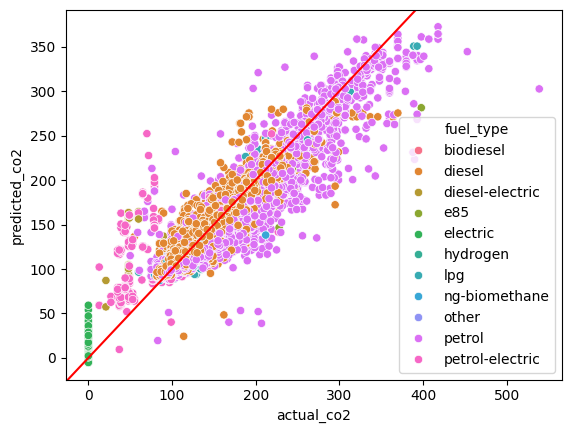

In [27]:
results = pd.DataFrame(dict(
    actual_co2=y_test,
    predicted_co2=y_pred,
    prediction_error=y_test - y_pred,
    absolute_error=np.abs(y_test - y_pred),
    squared_error=(y_test - y_pred)**2,
    mass_running_order_in_kg=X_test.mass_running_order_in_kg,
    engine_power_in_kilowatts=X_test.engine_power_in_kilowatts,
    fuel_type=X_test.fuel_type,
))

g = sns.scatterplot(
    data=results,
    x='actual_co2',
    y='predicted_co2',
    hue='fuel_type',
)

g.axline((0,0), (100,100), color='red')

In [28]:
results.sort_values(by='prediction_error')

,actual_co2,predicted_co2,prediction_error,absolute_error,squared_error,mass_running_order_in_kg,engine_power_in_kilowatts,fuel_type
vehicle_id,,,,,,,,
357555,70.0,252.267329,-182.267329,182.267329,33221.379220,1709.0,NaN,petrol-electric
19202,72.0,227.629824,-155.629824,155.629824,24220.641970,1773.0,447.0,petrol-electric
145668,76.0,213.136251,-137.136251,137.136251,18806.351325,2195.0,245.0,petrol
181423,104.0,232.124243,-128.124243,128.124243,16415.821712,1050.0,NaN,petrol
160415,39.0,162.849055,-123.849055,123.849055,15338.588400,1722.0,115.0,petrol-electric
...,...,...,...,...,...,...,...,...
406165,203.0,52.075853,150.924147,150.924147,22778.098075,1180.0,160.0,petrol
325550,388.0,231.234912,156.765088,156.765088,24575.292865,1715.0,271.0,petrol
138504,390.0,223.290355,166.709645,166.709645,27792.105608,1626.0,430.0,petrol


In [29]:
with_predictions = (
    X_test
    .assign(
        actual_co2=y_test,
        predicted_co2=y_pred,
        prediction_error=y_test - y_pred,
        absolute_error=np.abs(y_test - y_pred),
        squared_error=(y_test - y_pred)**2,
        number_of_nulls=lambda x: x.isnull().sum(axis='columns'),
        number_of_numerical_nulls=lambda x: x.select_dtypes(include=['float64', 'int64']).isnull().sum(axis='columns'),
    )
)

with_predictions.sort_values(by='prediction_error')

,total_new_registrations,mass_running_order_in_kg,wheel_base_in_mm,steering_axle_width_in_mm,other_axle_width_in_mm,engine_capacity_in_cm3,engine_power_in_kilowatts,electric_energy_consumption_in_watthours_per_km,country,pool,fuel_mode,fuel_type,actual_co2,predicted_co2,prediction_error,absolute_error,squared_error,number_of_nulls,number_of_numerical_nulls
vehicle_id,,,,,,,,,,,,,,,,,,,
357555,2,1709.0,2730.0,1648.0,1612.0,4593.0,NaN,NaN,NL,NaN,M,petrol-electric,70.0,252.267329,-182.267329,182.267329,33221.379220,3,2
19202,1,1773.0,2730.0,1648.0,1612.0,4593.0,447.0,127.0,AT,VW GROUP PC,M,petrol-electric,72.0,227.629824,-155.629824,155.629824,24220.641970,0,0
145668,1,2195.0,NaN,NaN,NaN,2995.0,245.0,NaN,DE,VW GROUP PC,M,petrol,76.0,213.136251,-137.136251,137.136251,18806.351325,4,4
181423,1,1050.0,2538.0,1470.0,1472.0,3750.0,NaN,NaN,ES,NaN,M,petrol,104.0,232.124243,-128.124243,128.124243,16415.821712,3,2
160415,1,1722.0,NaN,NaN,NaN,1395.0,115.0,NaN,DE,VW GROUP PC,M,petrol-electric,39.0,162.849055,-123.849055,123.849055,15338.588400,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406165,1,1180.0,2270.0,1390.0,1480.0,NaN,160.0,NaN,SE,NaN,M,petrol,203.0,52.075853,150.924147,150.924147,22778.098075,3,2
325550,1,1715.0,2660.0,NaN,NaN,3217.0,271.0,NaN,IT,NaN,M,petrol,388.0,231.234912,156.765088,156.765088,24575.292865,4,3
138504,1,1626.0,NaN,NaN,NaN,3982.0,430.0,NaN,DE,DAIMLER AG,M,petrol,390.0,223.290355,166.709645,166.709645,27792.105608,4,4


<Axes: ylabel='Frequency'>

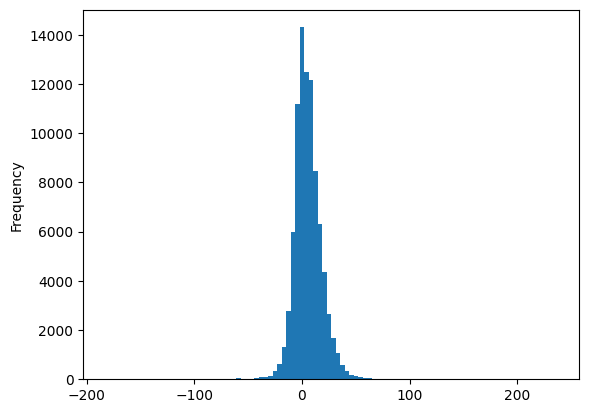

In [30]:
with_predictions.prediction_error.plot.hist(bins=100)

/Users/beaujeanpaul/Projects/intro-to-ai/.env/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/beaujeanpaul/Projects/intro-to-ai/.env/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/beaujeanpaul/Projects/intro-to-ai/.env/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_

<Axes: xlabel='prediction_error', ylabel='Count'>

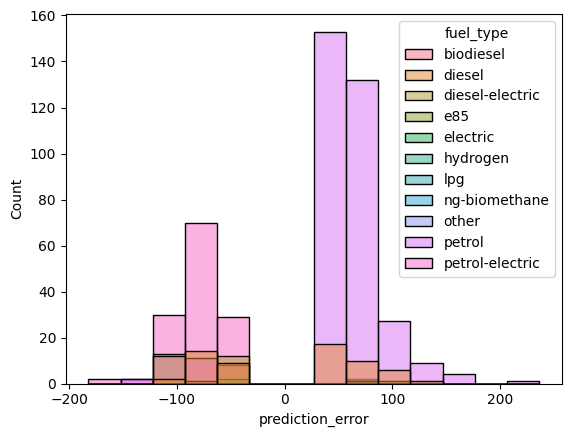

In [31]:
sns.histplot(
    data=with_predictions[with_predictions.absolute_error > 50],
    hue='fuel_type',
    x='prediction_error',
)

/Users/beaujeanpaul/Projects/intro-to-ai/.env/lib/python3.11/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


<Axes: xlabel='number_of_numerical_nulls', ylabel='prediction_error'>

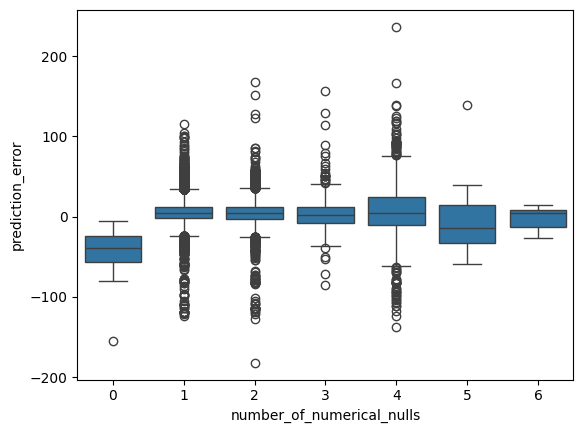

In [32]:
sns.boxplot(
    data=with_predictions,
    x='number_of_numerical_nulls',
    y='prediction_error',
)